In [3]:
%pip install pandas numpy scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 39.4 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 53.2 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 39.1 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 46.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 53.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 43.2 MB/s  0:00:006m0:00:0100:01
   ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  3/14 [numpy]]  WARNING: The scripts f2py and numpy-config are installed in '/usr/local/python/3.12.1/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━  6/14 [fonttools]  WARNING: 

In [4]:
df = pd.read_csv('../data/collisions_clean.csv', parse_dates=['CRASH DATE'])

print(f'Loaded dataset: {len(df):,} records, {df.shape[1]} columns')
print(f'Date range: {df["CRASH DATE"].min().date()} to {df["CRASH DATE"].max().date()}')
df.head(3)

Loaded dataset: 375,025 records, 39 columns
Date range: 2022-02-03 to 2026-01-30


,COLLISION_ID,CRASH DATE,year,month,day_of_week,hour,is_weekend,time_period,season,BOROUGH,...,has_pedestrian_casualty,has_cyclist_casualty,primary_factor,factor_category,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,vehicle_type_clean,num_vehicles,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2
0,4500092,2022-02-03,2022,2,3,16,0,Evening Rush,Winter,QUEENS,...,0,0,NaN,Unknown,NaN,NaN,Unknown,0,NaN,NaN
1,4504654,2022-02-03,2022,2,3,18,0,Evening Rush,Winter,MANHATTAN,...,0,1,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,Pedestrian/Cyclist Error,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,NaN,Sedan,2,Sedan,Bike
2,4504817,2022-02-03,2022,2,3,22,0,Night,Winter,QUEENS,...,0,0,NaN,Unknown,NaN,NaN,Pickup Truck,1,Pick-up Truck,NaN


In [5]:
# Core temporal features (ensure they exist)
df['year'] = df['CRASH DATE'].dt.year
df['month'] = df['CRASH DATE'].dt.month
df['day_of_week'] = df['CRASH DATE'].dt.dayofweek  # Monday=0, Sunday=6
df['day_of_month'] = df['CRASH DATE'].dt.day

# Hour should already exist from M2, but ensure it's clean
df['hour'] = pd.to_numeric(df['hour'], errors='coerce')

# Season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['month'].apply(get_season)

# Time-of-day intervals
def time_interval(hour):
    if pd.isna(hour):
        return 'Unknown'
    hour = int(hour)
    if 6 <= hour <= 9:
        return 'Morning Rush'
    elif 10 <= hour <= 15:
        return 'Midday'
    elif 16 <= hour <= 19:
        return 'Evening Rush'
    elif 20 <= hour <= 23:
        return 'Night'
    else:
        return 'Late Night'

df['time_interval'] = df['hour'].apply(time_interval)

# Weekend flag
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

print('Temporal features created:')
print(f'  year, month, day_of_week, day_of_month, hour')
print(f'  season, time_interval, is_weekend')

print(f'\nSeason distribution:')
print(df['season'].value_counts())

print(f'\nTime interval distribution:')
print(df['time_interval'].value_counts())

print(f'\nWeekend vs Weekday:')
print(df['is_weekend'].value_counts().rename({0: 'Weekday', 1: 'Weekend'}))

Temporal features created:
  year, month, day_of_week, day_of_month, hour
  season, time_interval, is_weekend

Season distribution:
season
Summer    96712
Spring    96619
Fall      96107
Winter    85587
Name: count, dtype: int64

Time interval distribution:
time_interval
Midday          114024
Evening Rush     86240
Morning Rush     61641
Night            57700
Late Night       55420
Name: count, dtype: int64

Weekend vs Weekday:
is_weekend
Weekday    272484
Weekend    102541
Name: count, dtype: int64


In [6]:
# --- Borough one-hot encoding ---
df['BOROUGH'] = df['BOROUGH'].fillna('Unknown')

borough_dummies = pd.get_dummies(df['BOROUGH'], prefix='BORO')
df = pd.concat([df, borough_dummies], axis=1)

print('Borough indicators created:')
print([col for col in df.columns if col.startswith('BORO_')])
print(f'\nBorough distribution:')
print(df['BOROUGH'].value_counts())

# --- ZIP code grouping (first 3 digits) ---
df['ZIP CODE'] = df['ZIP CODE'].fillna(0).astype(int)
df['zip_group'] = df['ZIP CODE'].astype(str).str[:3]

# Replace '0' (from NaN) with 'Unknown'
df['zip_group'] = df['zip_group'].replace('0', 'Unknown')

zip_dummies = pd.get_dummies(df['zip_group'], prefix='ZIP')
df = pd.concat([df, zip_dummies], axis=1)

print(f'\nZIP code groups created: {len([c for c in df.columns if c.startswith("ZIP_")])} groups')
print(f'Top ZIP groups:')
print(df['zip_group'].value_counts().head(10))

Borough indicators created:
['BORO_BRONX', 'BORO_BROOKLYN', 'BORO_MANHATTAN', 'BORO_QUEENS', 'BORO_STATEN ISLAND', 'BORO_Unknown']

Borough distribution:
BOROUGH
Unknown          107551
BROOKLYN          93151
QUEENS            71687
MANHATTAN         48948
BRONX             42789
STATEN ISLAND     10899
Name: count, dtype: int64

ZIP code groups created: 13 groups
Top ZIP groups:
zip_group
Unknown    107607
112         93208
100         47684
104         42789
113         32729
114         26588
103         10898
111          8324
116          3265
101          1120
Name: count, dtype: int64


In [8]:
# --- Vehicle type encoding ---
df['vehicle_type_clean'] = df['vehicle_type_clean'].fillna('Unknown')

veh_dummies = pd.get_dummies(df['vehicle_type_clean'], prefix='VEH_TYPE')
df = pd.concat([df, veh_dummies], axis=1)

print('Vehicle type indicators created:')
print([col for col in df.columns if col.startswith('VEH_TYPE_')])
print(f'\nVehicle type distribution:')
print(df['vehicle_type_clean'].value_counts())

Vehicle type indicators created:
['VEH_TYPE_Bicycle', 'VEH_TYPE_Bus', 'VEH_TYPE_E-Bike/E-Scooter', 'VEH_TYPE_Emergency Vehicle', 'VEH_TYPE_Moped', 'VEH_TYPE_Motorcycle', 'VEH_TYPE_Other', 'VEH_TYPE_Pickup Truck', 'VEH_TYPE_SUV/Station Wagon', 'VEH_TYPE_Sedan', 'VEH_TYPE_Taxi', 'VEH_TYPE_Truck', 'VEH_TYPE_Unknown', 'VEH_TYPE_Bicycle', 'VEH_TYPE_Bus', 'VEH_TYPE_E-Bike/E-Scooter', 'VEH_TYPE_Emergency Vehicle', 'VEH_TYPE_Moped', 'VEH_TYPE_Motorcycle', 'VEH_TYPE_Other', 'VEH_TYPE_Pickup Truck', 'VEH_TYPE_SUV/Station Wagon', 'VEH_TYPE_Sedan', 'VEH_TYPE_Taxi', 'VEH_TYPE_Truck', 'VEH_TYPE_Unknown']

Vehicle type distribution:
vehicle_type_clean
Sedan                171465
SUV/Station Wagon    128747
Other                 11118
Taxi                  10783
Truck                  9963
Pickup Truck           8823
Bus                    7234
Bicycle                7068
Unknown                6092
E-Bike/E-Scooter       4800
Motorcycle             3739
Moped                  2670
Emergency Vehicle  

In [9]:
# --- Contributing factor encoding ---
# Use factor_category (grouped) instead of raw factors to avoid too many columns
df['factor_category'] = df['factor_category'].fillna('Unknown')

factor_dummies = pd.get_dummies(df['factor_category'], prefix='FACTOR')
df = pd.concat([df, factor_dummies], axis=1)

print('Factor category indicators created:')
print([col for col in df.columns if col.startswith('FACTOR_')])
print(f'\nFactor category distribution:')
print(df['factor_category'].value_counts())

Factor category indicators created:
['FACTOR_Backing Unsafely', 'FACTOR_Distracted Driving', 'FACTOR_Driver Inexperience', 'FACTOR_Failure to Yield', 'FACTOR_Fatigue/Drowsy', 'FACTOR_Following Too Closely', 'FACTOR_Impaired Driving', 'FACTOR_Improper Lane Use/Passing', 'FACTOR_Improper Turning', 'FACTOR_Other', 'FACTOR_Pedestrian/Cyclist Error', 'FACTOR_Road Conditions', 'FACTOR_Speeding', 'FACTOR_Traffic Control Violation', 'FACTOR_Unknown', 'FACTOR_Vehicle Defect', 'FACTOR_Visibility Issues']

Factor category distribution:
factor_category
Unknown                      94626
Distracted Driving           94414
Improper Lane Use/Passing    36651
Failure to Yield             25839
Following Too Closely        22766
Other                        21152
Speeding                     13479
Backing Unsafely             11318
Traffic Control Violation    10652
Improper Turning              8712
Driver Inexperience           7896
Impaired Driving              7185
Road Conditions               614

In [10]:
# --- Also encode raw contributing factors (Vehicle 1 and 2) for alternative modeling ---
df['CONTRIBUTING FACTOR VEHICLE 1'] = df['CONTRIBUTING FACTOR VEHICLE 1'].fillna('Unknown')
df['CONTRIBUTING FACTOR VEHICLE 2'] = df['CONTRIBUTING FACTOR VEHICLE 2'].fillna('Unknown')

factor1_dummies = pd.get_dummies(df['CONTRIBUTING FACTOR VEHICLE 1'], prefix='FACTOR1')
factor2_dummies = pd.get_dummies(df['CONTRIBUTING FACTOR VEHICLE 2'], prefix='FACTOR2')
df = pd.concat([df, factor1_dummies, factor2_dummies], axis=1)

print(f'\nRaw factor indicators: {len([c for c in df.columns if c.startswith("FACTOR1_")])} for Vehicle 1, '
      f'{len([c for c in df.columns if c.startswith("FACTOR2_")])} for Vehicle 2')


Raw factor indicators: 55 for Vehicle 1, 53 for Vehicle 2


In [11]:
# --- Season and time interval encoding ---
season_dummies = pd.get_dummies(df['season'], prefix='SEASON')
time_dummies = pd.get_dummies(df['time_interval'], prefix='TIME')
df = pd.concat([df, season_dummies, time_dummies], axis=1)

print('Season indicators:', [c for c in df.columns if c.startswith('SEASON_')])
print('Time interval indicators:', [c for c in df.columns if c.startswith('TIME_')])

Season indicators: ['SEASON_Fall', 'SEASON_Spring', 'SEASON_Summer', 'SEASON_Winter']
Time interval indicators: ['TIME_Evening Rush', 'TIME_Late Night', 'TIME_Midday', 'TIME_Morning Rush', 'TIME_Night']


In [12]:
# --- Summary of all encoded features ---
print('=' * 60)
print('ENCODED FEATURES SUMMARY')
print('=' * 60)

feature_groups = {
    'Borough (BORO_)': len([c for c in df.columns if c.startswith('BORO_')]),
    'ZIP group (ZIP_)': len([c for c in df.columns if c.startswith('ZIP_')]),
    'Vehicle type (VEH_TYPE_)': len([c for c in df.columns if c.startswith('VEH_TYPE_')]),
    'Factor category (FACTOR_)': len([c for c in df.columns if c.startswith('FACTOR_') and not c.startswith('FACTOR1_') and not c.startswith('FACTOR2_')]),
    'Raw Factor V1 (FACTOR1_)': len([c for c in df.columns if c.startswith('FACTOR1_')]),
    'Raw Factor V2 (FACTOR2_)': len([c for c in df.columns if c.startswith('FACTOR2_')]),
    'Season (SEASON_)': len([c for c in df.columns if c.startswith('SEASON_')]),
    'Time interval (TIME_)': len([c for c in df.columns if c.startswith('TIME_')]),
}

for group, count in feature_groups.items():
    print(f'  {group}: {count} columns')

print(f'\nTotal columns in dataset: {df.shape[1]}')

ENCODED FEATURES SUMMARY
  Borough (BORO_): 6 columns
  ZIP group (ZIP_): 13 columns
  Vehicle type (VEH_TYPE_): 26 columns
  Factor category (FACTOR_): 17 columns
  Raw Factor V1 (FACTOR1_): 55 columns
  Raw Factor V2 (FACTOR2_): 53 columns
  Season (SEASON_): 4 columns
  Time interval (TIME_): 5 columns

Total columns in dataset: 221


TARGET VARIABLE DISTRIBUTION

Binary target (target_severity):
target_severity
No Injury (0)       217750
Injury/Fatal (1)    157275
Name: count, dtype: int64
Positive class rate: 41.9%

Multi-class severity (severity_level):
severity_level
Property Damage (0)    217750
Injury (1)             156272
Fatal (2)                1003
Name: count, dtype: int64

Casualty count statistics (total_casualties):
count    375025.000000
mean          0.561904
std           0.849291
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          40.000000
Name: total_casualties, dtype: float64


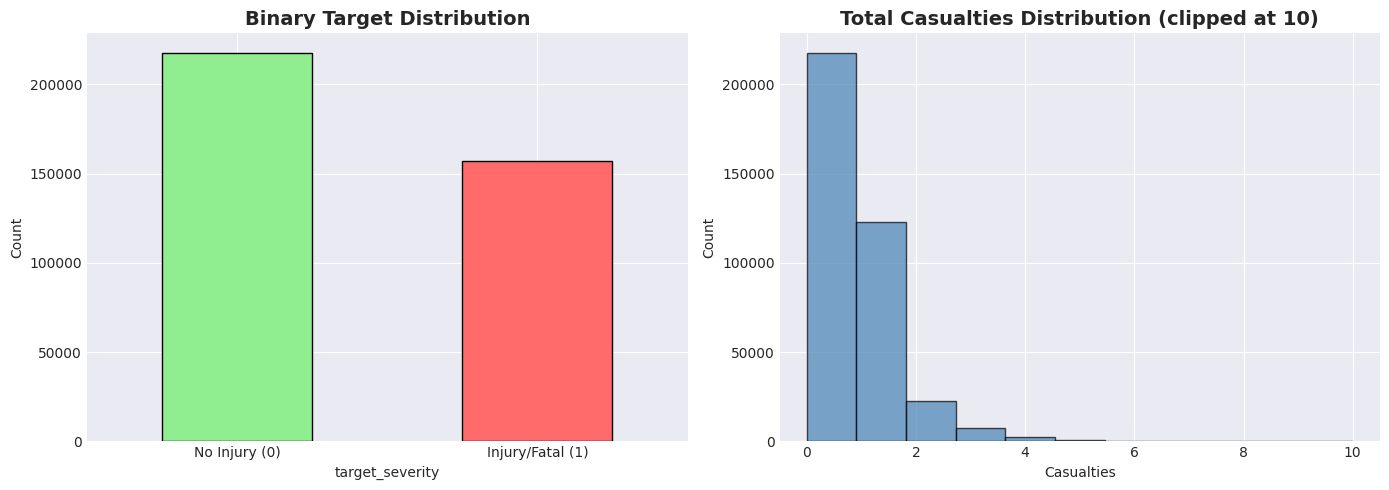

In [13]:
# Binary target: serious collision (Injury or Fatal) vs Property Damage Only
df['target_severity'] = df['severity'].apply(
    lambda x: 1 if x in ['Injury', 'Fatal'] else 0
)

# Total casualties count (injured + killed across all road user types)
df['total_casualties'] = (
    df['NUMBER OF PERSONS INJURED'] + df['NUMBER OF PERSONS KILLED']
)

# Multi-class severity for alternative modeling
severity_map = {'Property Damage Only': 0, 'Injury': 1, 'Fatal': 2}
df['severity_level'] = df['severity'].map(severity_map)

print('=' * 60)
print('TARGET VARIABLE DISTRIBUTION')
print('=' * 60)

print(f'\nBinary target (target_severity):')
print(df['target_severity'].value_counts().rename({0: 'No Injury (0)', 1: 'Injury/Fatal (1)'}))
print(f'Positive class rate: {df["target_severity"].mean()*100:.1f}%')

print(f'\nMulti-class severity (severity_level):')
print(df['severity_level'].value_counts().sort_index().rename({0: 'Property Damage (0)', 1: 'Injury (1)', 2: 'Fatal (2)'}))

print(f'\nCasualty count statistics (total_casualties):')
print(df['total_casualties'].describe())

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['target_severity'].value_counts().plot(kind='bar', ax=axes[0],
    color=['#90EE90', '#FF6B6B'], edgecolor='black')
axes[0].set_title('Binary Target Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(['No Injury (0)', 'Injury/Fatal (1)'], rotation=0)
axes[0].set_ylabel('Count')

df['total_casualties'].clip(upper=10).plot(kind='hist', bins=11, ax=axes[1],
    color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_title('Total Casualties Distribution (clipped at 10)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Casualties')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [14]:
# Temporal cutoff: train on 2022-2023, test on 2024+
temporal_cutoff = pd.to_datetime('2024-01-01')

train_df = df[df['CRASH DATE'] < temporal_cutoff].copy()
test_df = df[df['CRASH DATE'] >= temporal_cutoff].copy()

print('=' * 60)
print('TRAIN / TEST SPLIT')
print('=' * 60)
print(f'Temporal cutoff: {temporal_cutoff.date()}')
print(f'\nTrain set: {len(train_df):,} records ({len(train_df)/len(df)*100:.1f}%)')
print(f'  Date range: {train_df["CRASH DATE"].min().date()} to {train_df["CRASH DATE"].max().date()}')
print(f'  Target rate: {train_df["target_severity"].mean()*100:.1f}% Injury/Fatal')

print(f'\nTest set:  {len(test_df):,} records ({len(test_df)/len(df)*100:.1f}%)')
print(f'  Date range: {test_df["CRASH DATE"].min().date()} to {test_df["CRASH DATE"].max().date()}')
print(f'  Target rate: {test_df["target_severity"].mean()*100:.1f}% Injury/Fatal')

TRAIN / TEST SPLIT
Temporal cutoff: 2024-01-01

Train set: 192,037 records (51.2%)
  Date range: 2022-02-03 to 2023-12-31
  Target rate: 40.2% Injury/Fatal

Test set:  182,988 records (48.8%)
  Date range: 2024-01-01 to 2026-01-30
  Target rate: 43.8% Injury/Fatal


In [15]:
# Verify target distribution is consistent across splits
print('\nTarget distribution comparison:')
print(f'  Train — Injury/Fatal: {train_df["target_severity"].mean()*100:.1f}%')
print(f'  Test  — Injury/Fatal: {test_df["target_severity"].mean()*100:.1f}%')

print(f'\nSeverity breakdown:')
print('Train:')
print(train_df['severity'].value_counts().to_string())
print('\nTest:')
print(test_df['severity'].value_counts().to_string())


Target distribution comparison:
  Train — Injury/Fatal: 40.2%
  Test  — Injury/Fatal: 43.8%

Severity breakdown:
Train:
severity
Property Damage Only    114849
Injury                   76661
Fatal                      527

Test:
severity
Property Damage Only    102901
Injury                   79611
Fatal                      476


In [16]:
# Define feature columns for modeling (exclude targets, IDs, raw text, dates)
exclude_cols = [
    'COLLISION_ID', 'CRASH DATE', 'ON STREET NAME', 'CROSS STREET NAME',
    'severity', 'severity_level', 'target_severity',
    'total_injured', 'total_killed', 'total_casualties',
    'has_injury', 'has_fatality', 'has_pedestrian_casualty', 'has_cyclist_casualty',
    'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
    'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
    'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
    'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
    'BOROUGH', 'ZIP CODE', 'zip_group',
    'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
    'vehicle_type_clean', 'factor_category', 'primary_factor',
    'season', 'time_interval', 'time_period',
    'LATITUDE', 'LONGITUDE',
    'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
]

feature_cols = [c for c in df.columns if c not in exclude_cols]

print(f'Feature columns for modeling: {len(feature_cols)}')
print(f'\nSample features:')
for col in feature_cols[:20]:
    print(f'  {col}')
if len(feature_cols) > 20:
    print(f'  ... and {len(feature_cols) - 20} more')

Feature columns for modeling: 186

Sample features:
  year
  month
  day_of_week
  hour
  is_weekend
  num_vehicles
  day_of_month
  BORO_BRONX
  BORO_BROOKLYN
  BORO_MANHATTAN
  BORO_QUEENS
  BORO_STATEN ISLAND
  BORO_Unknown
  ZIP_100
  ZIP_101
  ZIP_102
  ZIP_103
  ZIP_104
  ZIP_110
  ZIP_111
  ... and 166 more


In [17]:
# Prepare X and y for modeling
X_train = train_df[feature_cols].fillna(0)
X_test = test_df[feature_cols].fillna(0)
y_train = train_df['target_severity']
y_test = test_df['target_severity']

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape:  {X_test.shape}')
print(f'y_train shape: {y_train.shape} — positive rate: {y_train.mean()*100:.1f}%')
print(f'y_test shape:  {y_test.shape} — positive rate: {y_test.mean()*100:.1f}%')

X_train shape: (192037, 212)
X_test shape:  (182988, 212)
y_train shape: (192037,) — positive rate: 40.2%
y_test shape:  (182988,) — positive rate: 43.8%


In [18]:
# Save train/test splits for Milestone 4
train_df.to_csv('../data/train.csv', index=False)
test_df.to_csv('../data/test.csv', index=False)

print(f'\nTrain set saved to: ../data/train.csv ({len(train_df):,} rows)')
print(f'Test set saved to:  ../data/test.csv ({len(test_df):,} rows)')


Train set saved to: ../data/train.csv (192,037 rows)
Test set saved to:  ../data/test.csv (182,988 rows)
